# **Training**: Physics-based Learned Design


**Purpose:** Train a physics-based network to learn the experiment design (LED patterns) for Fourier Ptychographic Microscopy.

**Monitor Training:** If you have enabled tensorboards (```tensorboard=True```), start the tensorboard (```tensorboard --logdir runs```) and the training can be monitored during training at the specified link.

**Parameters:**
* path (string) - _training dataset path_
* training_iter (int) - _number of iterations for training_
* step_size (float) - _step size for training_
* batch_size (int) - _batch size per training iteration_
* num_batch (int) - _number of batches_
* loss (string) - _loss function for training (mse on the complex value, mse on the amplitude, mse on the phase)_
* test_freq (int) - _test dataset evaluated every number of training iterations_
* optim (string) - _optimizer for training (_e.g._ adam, sgd)_
* gpu (int) - _GPU device number used for training (-1 for cpu)_
* verbose (bool) - _prints extra outputs_
* tensorboard (bool) - _writes out intermediate training information to a tensorboard_
* alpha (float) - _step size for physics-based network_
* num_meas (int) - _number of measurements for the learned design_
* num_bf (int) - _number of bright-field images for learned design constraint_
* num_df (int) - _number of dark-field images for learned design constraint_
* num_unrolls (int) - _number of layers for physics-based network_

**Author:** Michael Kellman (kellman dot berkeley dot edu)

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import os
import sys
import time
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from datetime import datetime
import time

sys.path.append('./source/')
import dataloader
import visualizer
import model
from recon import evaluate, makeNetwork
from utility import getPhase, getAbs

def get_time_stamp():
    return str(datetime.now())[11:19] + '_'

def format_loss_monitor(batch, loss, time):
    return 'batch={0:3d} | loss={1:.5f} | log loss={2:2.3f} | time={3:2.3f}'.format(batch, loss, np.log10(loss), time)

In [7]:
# learning arguments
num_batches = 10
batch_size = 1
path = './data/test/' ### RUN GENERATE DATA AND PUT YOUR PATH HERE
training_iter = 100
step_size = 0.01
loss = 'abs' # other options include mse on only the abs or the phase)
test_freq = 1
optim = 'adam' # other options include sgd
gpu = 0 # if -1 then 'cpu'
verbose = False
tensorboard = False

# reconstruction arguments
alpha = 1e-1
num_meas = 8
num_bf = 2
num_df = 6
num_unrolls = 75

In [8]:
# Setup device
if gpu < 0:
    device = 'cpu'
else:
    torch.cuda.set_device(gpu)
    device = torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")

In [9]:
# Load dataset
dataset = dataloader.dataloader(path, batch_size, loadBatchFlag=True, device=device)
metadata = dataset.getMetadata()
metadata['Np'] = dataset[0][0].shape[2:]
metadata['num_bf'] = num_bf
metadata['num_df'] = num_df
metadata['num_unrolls'] = num_unrolls
metadata['alpha'] = alpha

['batch01.mat', 'metadata.mat', 'batch02.mat', 'batch03.mat', 'batch00.mat']
b
batch01.mat
m
b
batch02.mat
b
batch03.mat
b
batch00.mat


In [23]:
# Define network/reconstruction
network = model.model(metadata, device=device)

# Setup optimizer
tvars = network.network.parameters()
if optim == 'adam':
    optimizer = torch.optim.Adam(tvars, lr=step_size)
elif optim == 'sgd':
    optimizer = torch.optim.SGD(tvars, lr=step_size)
else:
    assert False, 'Not valid optimizer (sgd, adam)'

# Setup loss function
if loss == "mse":
    loss_func = lambda x1, x2: torch.mean((x1-x2)**2)
elif loss == "abs":
    loss_func = lambda x1, x2: torch.mean((getAbs(x1)-getAbs(x2))**2)
elif loss == "phase":
    loss_func = lambda x1, x2: torch.mean((getPhase(x1)-getPhase(x2))**2)
else:
    assert False, 'Not valid loss function (try mse)'

Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625


In [24]:
# Setup tensorboard writer
exp_string = 'batch_size={0:d}_stepsize={1:.3f}_loss_fn={8:}_optim={2:}_num_unrolls={3:d}_alpha={4:.3f}_num_df={5:d}_num_bf={6:d}_num_leds={7:d}'.format(batch_size, step_size, optim, num_unrolls, alpha, num_df, num_bf, metadata['Nleds'], loss)
exp_time = get_time_stamp()
exp_dir = './runs/' + exp_time + exp_string
if verbose: print(exp_dir)
if tensorboard: 
    writer = SummaryWriter(exp_dir)

## Training Physics-based learned Design

In [25]:
# training loop
for ii in range(training_iter):
    batch_index = np.mod(ii,num_batches-1)
    input_data, output_data = dataset[batch_index]        

    # forward evaluation (loop over batches)
    loss_training = 0.
    network.network.zero_grad()
    for bb in range(batch_size):
        zgFlag = bb == 0
        start_time = time.time()
        x0 = network.initialize(input_data[bb:bb+1,...].to(device), device=device)
        xN_tmp, _ = evaluate(network.network, x0, testFlag = False, device = device)
        loss_tmp = loss_func(output_data[bb:bb+1,...].to(device),xN_tmp)
        loss_tmp.backward()
        end_time = time.time()
        with torch.no_grad():
            loss_training += loss_tmp

    # gradient and projection updates
    optimizer.step()
    network.projection()


    # testing evaluation
    if np.mod(ii, test_freq) == 0:
        input_data, output_data = dataset[num_batches-1]            

        # forward evaluation (loop over batches)
        loss_testing = 0.
        for bb in range(batch_size):
            x0 = network.initialize(input_data[bb:bb+1,...].to(device), device = device)
            xN_test, _ = evaluate(network.network, x0, testFlag = True, device = device)
            loss_tmp = loss_func(output_data[bb:bb+1,...].to(device),xN_test)
            with torch.no_grad():
                loss_testing += loss_tmp.cpu().numpy()


        # tensorboard writer
        if tensorboard:
            # visualizing
            with torch.no_grad():
                fig = visualizer.visualize(network.grad.C.data.cpu().numpy(), metadata)
            os.system('mkdir -p ' + exp_dir + '/tmp/')
            img_file_path = exp_dir + '/tmp/leds_{0:4d}.png'.format(ii)
            fig.savefig(img_file_path, transparent=True, dpi=150)
            plt.close()
            led_img = mpimg.imread(img_file_path)[...,:3]


            # writing to tensorboard
            writer.add_scalar('Loss/test', loss_testing/batch_size, ii)
            writer.add_scalar('Loss/train', loss_training/batch_size, ii)
            writer.add_image('Visual/leds', led_img, ii, dataformats='HWC')


            # saving checkpoints
            saveDict = {'model_state_dict':network.network.state_dict(),
                        'loss_testing':loss_testing,
                        'loss_training':loss_training,
                        'alpha':alpha,
                        'num_unrolls':num_unrolls,
                        'num_meas':num_meas,
                        'num_bf':num_bf,
                        'num_df':num_df,
                       }             
            torch.save(saveDict, exp_dir + '/ckpt.tar')

    # progress print statement
    print(format_loss_monitor(ii, loss_testing / batch_size, end_time - start_time), end="\r")

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


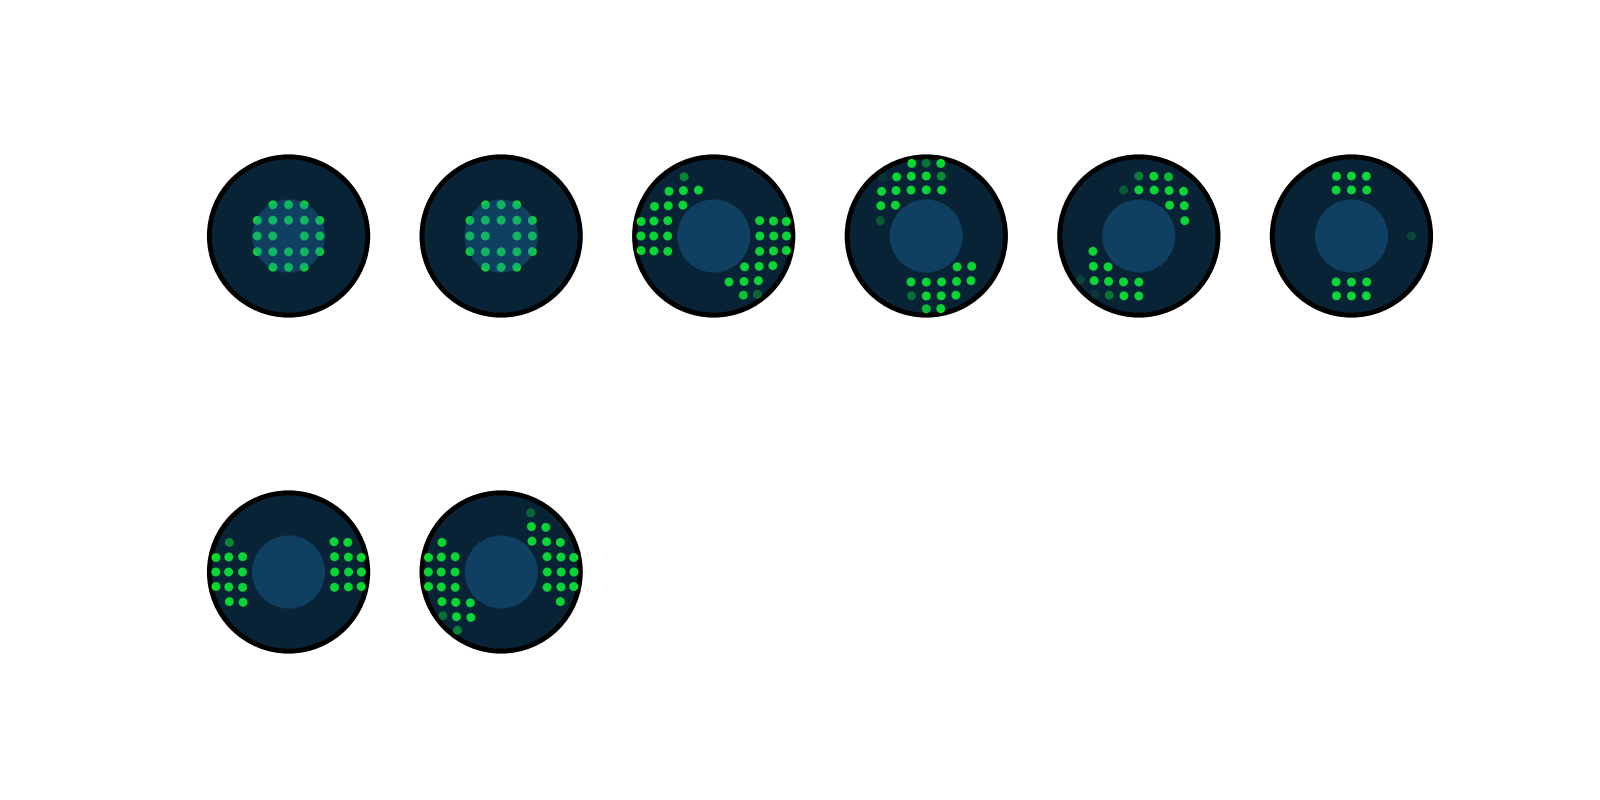

<IPython.core.display.Javascript object>


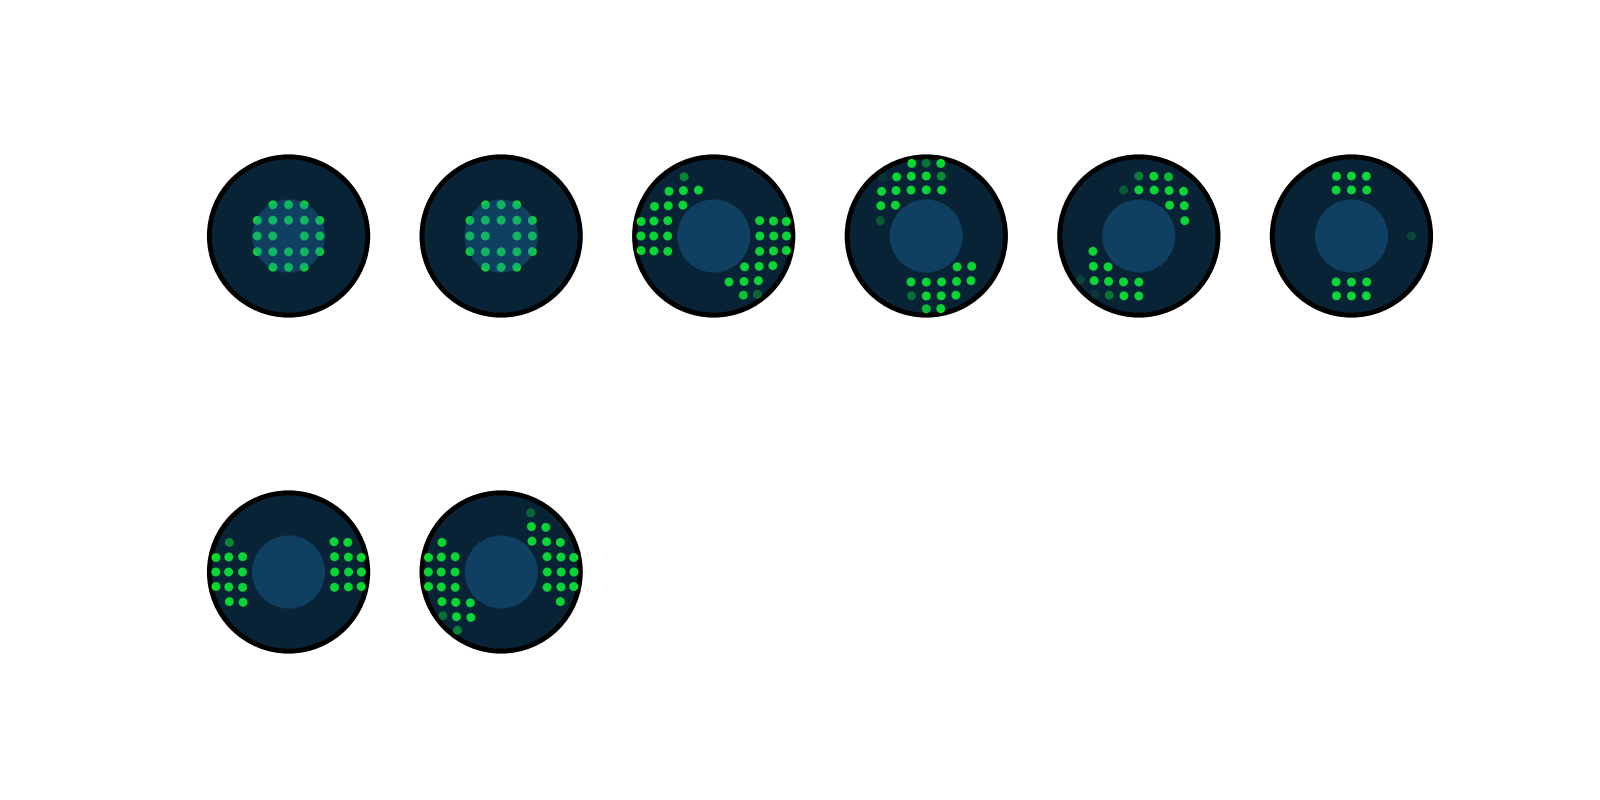

In [26]:
visualizer.visualize(network.grad.C.detach().cpu().numpy(),metadata)